# FDIC Failed Bank as Reference Data

In [1]:
import pandas as pd

# Load the failed bank list
failed_banks = pd.read_csv('FDIC Failed Bank List.csv', encoding = 'latin1')
failed_banks.columns = failed_banks.columns.str.strip()
print(failed_banks.head())

# Standardize date
failed_banks['Closing Date'] = pd.to_datetime(failed_banks['Closing Date'])

# Build a quick lookup (Bank Name -> Closing Date)
failed_bank_lookup = failed_banks[['Bank Name', 'Closing Date', 'Cert']]
print(failed_bank_lookup.head())

                               Bank Name          City State   Cert  \
0                   Pulaski Savings Bank       Chicago    IL  28611   
1         First National Bank of Lindsay       Lindsay    OK   4134   
2  Republic First Bank dba Republic Bank  Philadelphia    PA  27332   
3                          Citizens Bank      Sac City    IA   8758   
4               Heartland Tri-State Bank       Elkhart    KS  25851   

               Acquiring Institution Closing Date   Fund  
0                    Millennium Bank    17-Jan-25  10548  
1             First Bank & Trust Co.    18-Oct-24  10547  
2  Fulton Bank, National Association    26-Apr-24  10546  
3          Iowa Trust & Savings Bank     3-Nov-23  10545  
4             Dream First Bank, N.A.    28-Jul-23  10544  
                               Bank Name Closing Date   Cert
0                   Pulaski Savings Bank   2025-01-17  28611
1         First National Bank of Lindsay   2024-10-18   4134
2  Republic First Bank dba Republic 

<ipython-input-1-1f62b863999c>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  failed_banks['Closing Date'] = pd.to_datetime(failed_banks['Closing Date'])


In [2]:
# Filter to recent failures
recent_failed_banks = failed_banks[failed_banks['Closing Date'] >= '2020-01-01']
recent_failed_banks = failed_banks.sort_values('Closing Date')
print(recent_failed_banks.head())

                             Bank Name        City State   Cert  \
570                   Bank of Honolulu    Honolulu    HI  21029   
569  National State Bank of Metropolis  Metropolis    IL   3815   
568    First Alliance Bank & Trust Co.  Manchester    NH  34264   
567                Malta National Bank       Malta    OH   6629   
566                 Superior Bank, FSB    Hinsdale    IL  32646   

                   Acquiring Institution Closing Date  Fund  
570                   Bank of the Orient   2000-10-13  4645  
569              Banterra Bank of Marion   2000-12-14  4646  
568  Southern New Hampshire Bank & Trust   2001-02-02  4647  
567                    North Valley Bank   2001-05-03  4648  
566                Superior Federal, FSB   2001-07-27  6004  


# Price Shocks on Peer Banks

In [12]:
import yfinance as yf
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt

# Peer bank tickers (surviving banks)
peer_banks = {
    "JPMorgan": "JPM",
    "Bank of America": "BAC",
    "Wells Fargo": "WFC",
    "PNC": "PNC",
    "US Bank": "USB",
    "Citizens Financial": "CFG",
    "Truist": "TFC",
}

# Download price history
tickers = list(peer_banks.values())
raw_data = yf.download(tickers, start = "2000-01-01", end = "2025-01-01")

[*********************100%***********************]  7 of 7 completed


In [13]:
import yfinance as yf

tickers = ["JPM", "BAC", "WFC", "PNC", "USB", "CFG", "TFC"]

# Download with group_by='ticker'
data = yf.download(tickers, start = "2000-01-01", end = "2025-01-01", group_by = 'ticker')

# Check structure
print(data.columns)

[*********************100%***********************]  7 of 7 completed

MultiIndex([('USB',   'Open'),
            ('USB',   'High'),
            ('USB',    'Low'),
            ('USB',  'Close'),
            ('USB', 'Volume'),
            ('BAC',   'Open'),
            ('BAC',   'High'),
            ('BAC',    'Low'),
            ('BAC',  'Close'),
            ('BAC', 'Volume'),
            ('CFG',   'Open'),
            ('CFG',   'High'),
            ('CFG',    'Low'),
            ('CFG',  'Close'),
            ('CFG', 'Volume'),
            ('TFC',   'Open'),
            ('TFC',   'High'),
            ('TFC',    'Low'),
            ('TFC',  'Close'),
            ('TFC', 'Volume'),
            ('PNC',   'Open'),
            ('PNC',   'High'),
            ('PNC',    'Low'),
            ('PNC',  'Close'),
            ('PNC', 'Volume'),
            ('WFC',   'Open'),
            ('WFC',   'High'),
            ('WFC',    'Low'),
            ('WFC',  'Close'),
            ('WFC', 'Volume'),
            ('JPM',   'Open'),
            ('JPM',   'High'),
        

In [14]:
price_data = data.xs('Close', level = 'Price', axis = 1)

In [15]:
from datetime import timedelta

results = []

for _, row in failed_bank_lookup.iterrows():
    fail_date = row['Closing Date']
    bank_name = row['Bank Name']

    for label, ticker in peer_banks.items():
        try:
            before = price_data.loc[fail_date - timedelta(days = 5), ticker]
            after = price_data.loc[fail_date + timedelta(days = 1), ticker]
            pct_change = (after - before) / before
            results.append({
                'Failed Bank': bank_name,
                'Failure Date': fail_date,
                'Peer Bank': label,
                'Ticker': ticker,
                'Pct Change (5d before → 1d after)': pct_change
            })
        except KeyError:
            continue

print(results)

[{'Failed Bank': 'First Republic Bank', 'Failure Date': Timestamp('2023-05-01 00:00:00'), 'Peer Bank': 'JPMorgan', 'Ticker': 'JPM', 'Pct Change (5d before → 1d after)': np.float64(0.027286851838903236)}, {'Failed Bank': 'First Republic Bank', 'Failure Date': Timestamp('2023-05-01 00:00:00'), 'Peer Bank': 'Bank of America', 'Ticker': 'BAC', 'Pct Change (5d before → 1d after)': np.float64(-0.009845217424967068)}, {'Failed Bank': 'First Republic Bank', 'Failure Date': Timestamp('2023-05-01 00:00:00'), 'Peer Bank': 'Wells Fargo', 'Ticker': 'WFC', 'Pct Change (5d before → 1d after)': np.float64(-0.015712002282439175)}, {'Failed Bank': 'First Republic Bank', 'Failure Date': Timestamp('2023-05-01 00:00:00'), 'Peer Bank': 'PNC', 'Ticker': 'PNC', 'Pct Change (5d before → 1d after)': np.float64(-0.06812674132191518)}, {'Failed Bank': 'First Republic Bank', 'Failure Date': Timestamp('2023-05-01 00:00:00'), 'Peer Bank': 'US Bank', 'Ticker': 'USB', 'Pct Change (5d before → 1d after)': np.float64(-0

In [19]:
import pandas as pd
df = pd.DataFrame(results)
summary = df.groupby('Peer Bank')['Pct Change (5d before → 1d after)'].mean().sort_values()
print(summary)

Peer Bank
Citizens Financial   -0.135311
Truist               -0.038871
PNC                  -0.025242
Wells Fargo          -0.019044
US Bank              -0.017663
Bank of America      -0.017496
JPMorgan              0.003316
Name: Pct Change (5d before → 1d after), dtype: float64


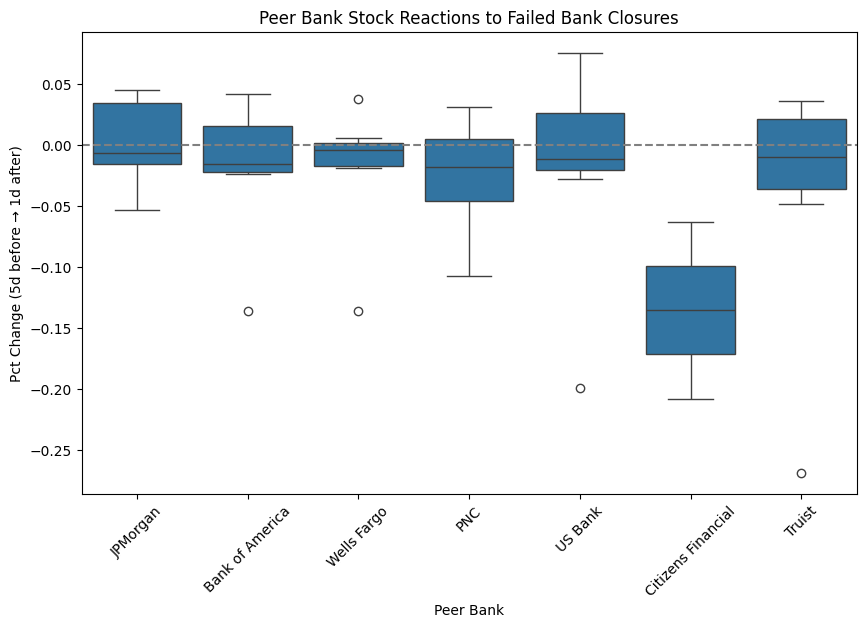

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (10,6))
sns.boxplot(data = df, x='Peer Bank', y = 'Pct Change (5d before → 1d after)')
plt.axhline(0, linestyle = '--', color = 'gray')
plt.title("Peer Bank Stock Reactions to Failed Bank Closures")
plt.xticks(rotation = 45)
plt.show()

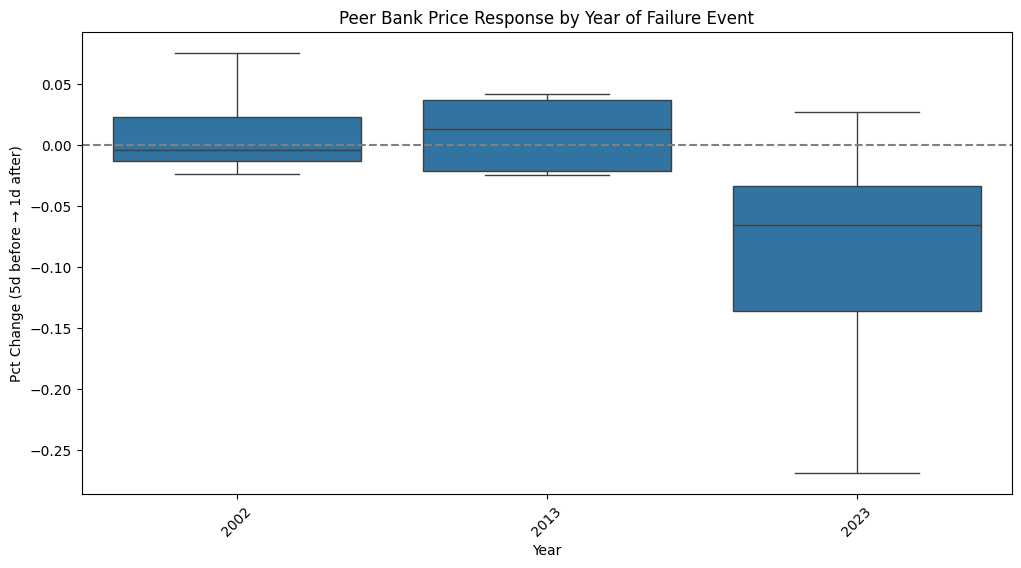

In [ ]:
df['Year'] = df['Failure Date'].dt.year

plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='Year', y='Pct Change (5d before → 1d after)')
plt.axhline(0, linestyle='--', color='gray')
plt.title("Peer Bank Price Response by Year of Failure Event")
plt.xticks(rotation=45)
plt.show()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3484 entries, 0 to 3483
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Financial Institution Number  2883 non-null   float64
 1   Institution Name              3484 non-null   object 
 2   Institution Type              3484 non-null   object 
 3   Charter Type                  3484 non-null   object 
 4   Headquarters                  3484 non-null   object 
 5   Failure Date                  3484 non-null   object 
 6   Insurance Fund                3484 non-null   object 
 7   Certificate Number            2999 non-null   float64
 8   Transaction Type              3484 non-null   object 
 9   Total Deposits                3484 non-null   int64  
 10  Total Assets                  3333 non-null   float64
 11  Estimated Loss (2015)         2509 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 326.8+ KB


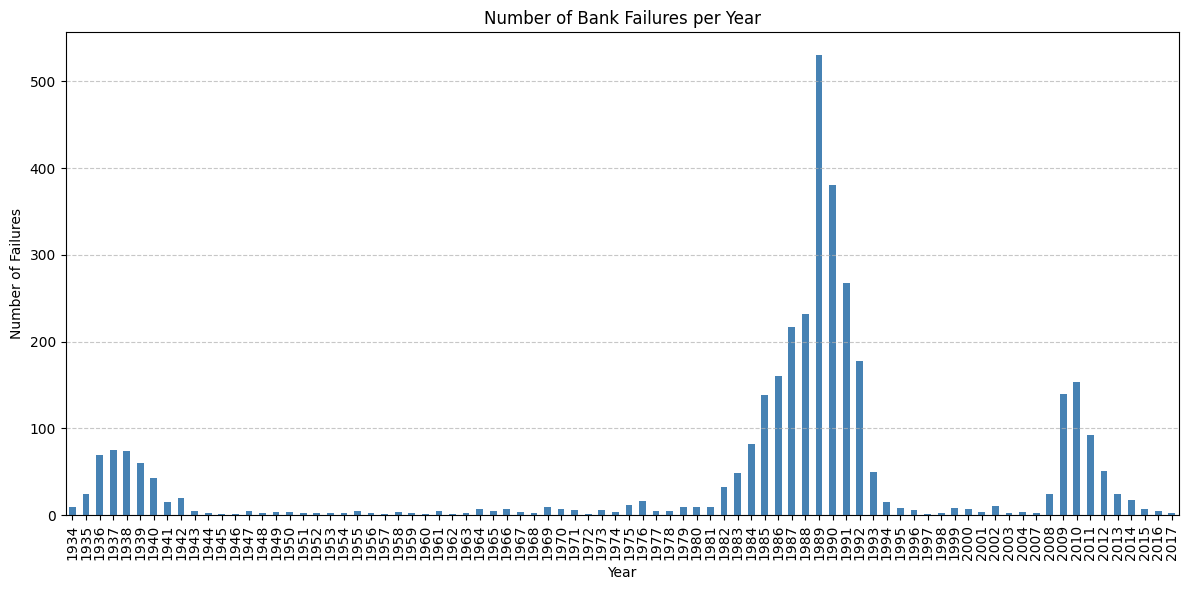

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# === Step 1: Load the dataset ===
file_path = "banks.csv"  # Adjust path if running outside notebook
banks_df = pd.read_csv(file_path)

# === Step 2: Inspect and clean ===
banks_df.info()                # Show structure
banks_df.head()               # Preview first few rows

# Convert 'Failure Date' to datetime format
banks_df['Failure Date'] = pd.to_datetime(banks_df['Failure Date'], errors='coerce')

# Extract the year of failure
banks_df['Failure Year'] = banks_df['Failure Date'].dt.year

# === Step 3: Plot histogram of failures per year ===
plt.figure(figsize=(12, 6))
banks_df['Failure Year'].value_counts().sort_index().plot(kind='bar', color='steelblue')
plt.title("Number of Bank Failures per Year")
plt.xlabel("Year")
plt.ylabel("Number of Failures")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## LM Dictionary-Based Sentiment Analysis


In [24]:
!wget -O dict.csv --no-check-certificate -r https://drive.google.com/uc?export=download\&id=17CmUZM9hGUdGYjCXcjQLyybjTrcjrhik

will be placed in the single file you specified.

--2025-05-01 15:01:42--  https://drive.google.com/uc?export=download&id=17CmUZM9hGUdGYjCXcjQLyybjTrcjrhik
Resolving drive.google.com (drive.google.com)... 173.194.216.100, 173.194.216.138, 173.194.216.113, ...
Connecting to drive.google.com (drive.google.com)|173.194.216.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=17CmUZM9hGUdGYjCXcjQLyybjTrcjrhik&export=download [following]
--2025-05-01 15:01:42--  https://drive.usercontent.google.com/download?id=17CmUZM9hGUdGYjCXcjQLyybjTrcjrhik&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.107.132, 2607:f8b0:400c:c32::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.107.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8880507 (8.5M) [application/octet-stream]
Saving to: ‘dict.csv’

dict.csv      

In [25]:
import pandas as pd
lmmd = pd.read_csv('dict.csv')
lmmd

,Word,Seq_num,Word Count,Word Proportion,Average Proportion,Std Dev,Doc Count,Negative,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining,Syllables,Source
0,AARDVARK,1,354,1.550080e-08,1.422600e-08,3.815486e-06,99,0,0,0,0,0,0,0,2,12of12inf
1,AARDVARKS,2,3,1.313627e-10,8.653817e-12,9.241714e-09,1,0,0,0,0,0,0,0,2,12of12inf
2,ABACI,3,9,3.940882e-10,1.169679e-10,5.290465e-08,7,0,0,0,0,0,0,0,3,12of12inf
3,ABACK,4,29,1.269840e-09,6.654735e-10,1.595100e-07,28,0,0,0,0,0,0,0,2,12of12inf
4,ABACUS,5,8570,3.752595e-07,3.809464e-07,3.529356e-05,1108,0,0,0,0,0,0,0,3,12of12inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86526,ZYGOTE,86529,50,2.189379e-09,8.729336e-10,1.886011e-07,35,0,0,0,0,0,0,0,2,12of12inf
86527,ZYGOTES,86530,1,4.378757e-11,1.809516e-11,1.932446e-08,1,0,0,0,0,0,0,0,2,12of12inf
86528,ZYGOTIC,86531,0,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,3,12of12inf
86529,ZYMURGIES,86532,0,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,3,12of12inf


In [20]:
from pyspark.sql import SparkSession
spark  = SparkSession \
    .builder \
    .appName("NerdyWordCounting") \
    .master("local[*]") \
    .config("spark.ui.port", "4050") \
    .getOrCreate()

sc = spark.sparkContext

In [21]:
!apt-get update
!apt install build-essential libpoppler-cpp-dev pkg-config python3-dev
!pip install pdftotext

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,607 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,844 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,244 kB]
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:13 https://r2u.stat.illi

In [22]:
import pdftotext

# Download the PDF
!wget https://s201.q4cdn.com/589201576/files/doc_financials/2022/q4/2022-Q4-SIVB-CEO-Letter.Final.pdf

# Read and convert to text
with open("2022-Q4-SIVB-CEO-Letter.Final.pdf", "rb") as f:
    pdf = pdftotext.PDF(f)

# Combine all pages into a single string
svb_text = "\n\n".join(pdf)

# Optional: Save to a .txt file
with open("SVB.txt", "w") as f:
    f.write(svb_text)

# Preview text
print(svb_text[:1000])

--2025-05-01 15:01:34--  https://s201.q4cdn.com/589201576/files/doc_financials/2022/q4/2022-Q4-SIVB-CEO-Letter.Final.pdf
Resolving s201.q4cdn.com (s201.q4cdn.com)... 68.70.205.4, 68.70.205.3, 68.70.205.1, ...
Connecting to s201.q4cdn.com (s201.q4cdn.com)|68.70.205.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 122694 (120K) [application/pdf]
Saving to: ‘2022-Q4-SIVB-CEO-Letter.Final.pdf’

2022-Q4-SIVB-CEO-Le 100%[===================>] 119.82K  --.-KB/s    in 0.04s   

2025-05-01 15:01:34 (3.20 MB/s) - ‘2022-Q4-SIVB-CEO-Letter.Final.pdf’ saved [122694/122694]

SVB Financial Group Q4 2022 CEO Letter

To our Stakeholders:
In the fourth quarter of 2022, SVB delivered Earnings Per Share of $4.62, Net Income of $275 million
and a Return on Equity of 8.9 percent. For the full year 2022, we delivered Earnings Per Share of
$25.35, Net income of $1.5 billion and a Return on Equity of 12.1 percent.
While broader market conditions are impacting growth, activity remaine

In [26]:
import re
import pandas as pd

# 1. Assuming you already have `svb_text` from the CEO letter
# 2. And `lmmd` is your loaded Loughran-McDonald dictionary from dict.csv

# Filter LM dictionary for each category
positive_words = set(lmmd[lmmd['Positive'] > 0]['Word'].str.lower())
negative_words = set(lmmd[lmmd['Negative'] > 0]['Word'].str.lower())
uncertainty_words = set(lmmd[lmmd['Uncertainty'] > 0]['Word'].str.lower())
litigious_words = set(lmmd[lmmd['Litigious'] > 0]['Word'].str.lower())

# Tokenize the text
words = re.findall(r'\b\w+\b', svb_text.lower())

# Count occurrences in each category
positive_count = sum(word in positive_words for word in words)
negative_count = sum(word in negative_words for word in words)
uncertainty_count = sum(word in uncertainty_words for word in words)
litigious_count = sum(word in litigious_words for word in words)

# Print results
print("SVB CEO Letter Sentiment Scores:")
print(f"✅ Positive: {positive_count}")
print(f"❌ Negative: {negative_count}")
print(f"❓ Uncertainty: {uncertainty_count}")
print(f"⚖️  Litigious: {litigious_count}")

SVB CEO Letter Sentiment Scores:
✅ Positive: 59
❌ Negative: 22
❓ Uncertainty: 24
⚖️  Litigious: 3


In [27]:
positive = set(lmmd[lmmd["Positive"] > 0]["Word"].str.lower())
negative = set(lmmd[lmmd["Negative"] > 0]["Word"].str.lower())
uncertainty = set(lmmd[lmmd["Uncertainty"] > 0]["Word"].str.lower())
litigious = set(lmmd[lmmd["Litigious"] > 0]["Word"].str.lower())
constraining = set(lmmd[lmmd["Constraining"] > 0]["Word"].str.lower())

from collections import Counter

counts = Counter(words)

def count_matches(wordset):
    return sum(counts[word] for word in wordset if word in counts)

sentiment_scores = {
    "Positive": count_matches(positive),
    "Negative": count_matches(negative),
    "Uncertainty": count_matches(uncertainty),
    "Litigious": count_matches(litigious),
    "Constraining": count_matches(constraining),
    "Net Sentiment (Pos - Neg)": count_matches(positive) - count_matches(negative)
}

import pandas as pd
svb_sentiment = pd.DataFrame.from_dict(sentiment_scores, orient="index", columns=["Count"])
print(svb_sentiment)

                           Count
Positive                      59
Negative                      22
Uncertainty                   24
Litigious                      3
Constraining                   3
Net Sentiment (Pos - Neg)     37


# Financial Analysis

In [28]:
# Load the sheet by skipping the title row and using the second row as header
df = pd.read_excel("Financial_Report.xlsx",
                   sheet_name="Interim Consolidated Balance Sh",
                   skiprows=1)

# Assign correct column names manually
df.columns = ['Metric', '2022-06-30', '2021-12-31']

# Set 'Metric' as index if you want row labels
df.set_index('Metric', inplace=True)

# Convert values to numeric if they aren't already
df = df.apply(pd.to_numeric, errors='coerce')

# Preview
print(df.head())


# Preview the cleaned DataFrame
print(df.head(10))

                                                    2022-06-30  2021-12-31
Metric                                                                    
Cash and cash equivalents                              15398.0     14619.0
Available-for-sale securities, at fair value (c...     26223.0     27221.0
Held-to-maturity securities, at amortized cost ...     95814.0     98195.0
Non-marketable and other equity securities              2645.0      2543.0
Total investment securities                           124682.0    127959.0
                                                    2022-06-30  2021-12-31
Metric                                                                    
Cash and cash equivalents                              15398.0     14619.0
Available-for-sale securities, at fair value (c...     26223.0     27221.0
Held-to-maturity securities, at amortized cost ...     95814.0     98195.0
Non-marketable and other equity securities              2645.0      2543.0
Total investment securiti

In [29]:
# Assuming df is the already loaded balance sheet DataFrame you showed

# Extract relevant financial figures
cash = df.loc["Cash and cash equivalents"]
afs = df.loc["Available-for-sale securities, at fair value (cost of $28,141 and $27,370, respectively)"]
htm = df.loc["Held-to-maturity securities, at amortized cost and net of allowance for credit losses of $6 and $7 (fair value of $84,579 and $97,227, respectively)"]
loans = df.loc["Loans, amortized cost"]
net_loans = df.loc["Net loans"]
deposits = df.loc["Total deposits"]
short_term_borrow = df.loc["Short-term borrowings"]
long_term_debt = df.loc["Long-term debt"]
total_assets = df.loc["Total investment securities"] + df.loc["Cash and cash equivalents"] + df.loc["Net loans"]
total_liabilities = df.loc["Total liabilities"]

# Compute key health indicators
metrics = pd.DataFrame({
    "Liquidity Ratio (Cash + AFS) / Deposits": (cash + afs) / deposits,
    "Loan-to-Deposit Ratio": net_loans / deposits,
    "Debt-to-Asset Ratio": (short_term_borrow + long_term_debt) / total_assets,
    "Leverage Ratio (Assets / Equity proxy)": total_assets / (total_assets - total_liabilities),
    "HTM as % of Total Securities": htm / (htm + afs),
})

print(metrics)


            Liquidity Ratio (Cash + AFS) / Deposits  Loan-to-Deposit Ratio  \
2022-06-30                                 0.221453               0.374631   
2021-12-31                                 0.221138               0.348060   

            Debt-to-Asset Ratio  Leverage Ratio (Assets / Equity proxy)  \
2022-06-30             0.033588                               17.006544   
2021-12-31             0.012911                               15.367692   

            HTM as % of Total Securities  
2022-06-30                      0.785123  
2021-12-31                      0.782954  


In [30]:
print(df.columns)

Index(['2022-06-30', '2021-12-31'], dtype='object')


In [31]:
import pdftotext

# Download the PDF
!wget https://www.federalreserve.gov/publications/files/financial-stability-report-20250425.pdf

# Read and convert to text
with open("financial-stability-report-20250425.pdf", "rb") as f:
    pdf = pdftotext.PDF(f)

# Combine all pages into a single string
fdic_text = "\n\n".join(pdf)

# Optional: Save to a .txt file
with open("FDIC.txt", "w") as f:
    f.write(fdic_text)

# Preview text
print(fdic_text[:1000])


--2025-05-01 15:02:08--  https://www.federalreserve.gov/publications/files/financial-stability-report-20250425.pdf
Resolving www.federalreserve.gov (www.federalreserve.gov)... 104.18.33.249, 172.64.154.7, 2606:4700:4400::ac40:9a07, ...
Connecting to www.federalreserve.gov (www.federalreserve.gov)|104.18.33.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4986389 (4.8M) [application/pdf]
Saving to: ‘financial-stability-report-20250425.pdf’

financial-stability 100%[===================>]   4.75M  --.-KB/s    in 0.09s   

2025-05-01 15:02:08 (50.1 MB/s) - ‘financial-stability-report-20250425.pdf’ saved [4986389/4986389]

Financial Stability Report

April 2025

B O A R D O F G O V E R N O R S O F T H E F E D E R A L R E S E RV E S Y S T E M



The Federal Reserve System is the central
bank of the United States. It performs five key
functions to promote the effective operation
of the U.S. economy and, more generally, the
public interest.
The Federal Reserve
■ c

In [32]:
positive = set(lmmd[lmmd["Positive"] > 0]["Word"].str.lower())
negative = set(lmmd[lmmd["Negative"] > 0]["Word"].str.lower())
uncertainty = set(lmmd[lmmd["Uncertainty"] > 0]["Word"].str.lower())
litigious = set(lmmd[lmmd["Litigious"] > 0]["Word"].str.lower())
constraining = set(lmmd[lmmd["Constraining"] > 0]["Word"].str.lower())


# Tokenize the text
words = re.findall(r'\b\w+\b', fdic_text.lower())

# Count occurrences in each category
positive_count = sum(word in positive_words for word in words)
negative_count = sum(word in negative_words for word in words)
uncertainty_count = sum(word in uncertainty_words for word in words)
litigious_count = sum(word in litigious_words for word in words)

# Print results
print("FDIC Sentiment Scores:")
print(f"✅ Positive: {positive_count}")
print(f"❌ Negative: {negative_count}")
print(f"❓ Uncertainty: {uncertainty_count}")
print(f"⚖️  Litigious: {litigious_count}")

FDIC Sentiment Scores:
✅ Positive: 132
❌ Negative: 512
❓ Uncertainty: 306
⚖️  Litigious: 30


In [33]:
from collections import Counter

counts = Counter(words)

def count_matches(wordset):
    return sum(counts[word] for word in wordset if word in counts)

fdic_sentiment_scores = {
    "Positive": count_matches(positive),
    "Negative": count_matches(negative),
    "Uncertainty": count_matches(uncertainty),
    "Litigious": count_matches(litigious),
    "Constraining": count_matches(constraining),
    "Net Sentiment (Pos - Neg)": count_matches(positive) - count_matches(negative)
}

import pandas as pd
fdic_sentiment = pd.DataFrame.from_dict(fdic_sentiment_scores, orient="index", columns=["Count"])
print(fdic_sentiment)


                           Count
Positive                     132
Negative                     512
Uncertainty                  306
Litigious                     30
Constraining                  67
Net Sentiment (Pos - Neg)   -380


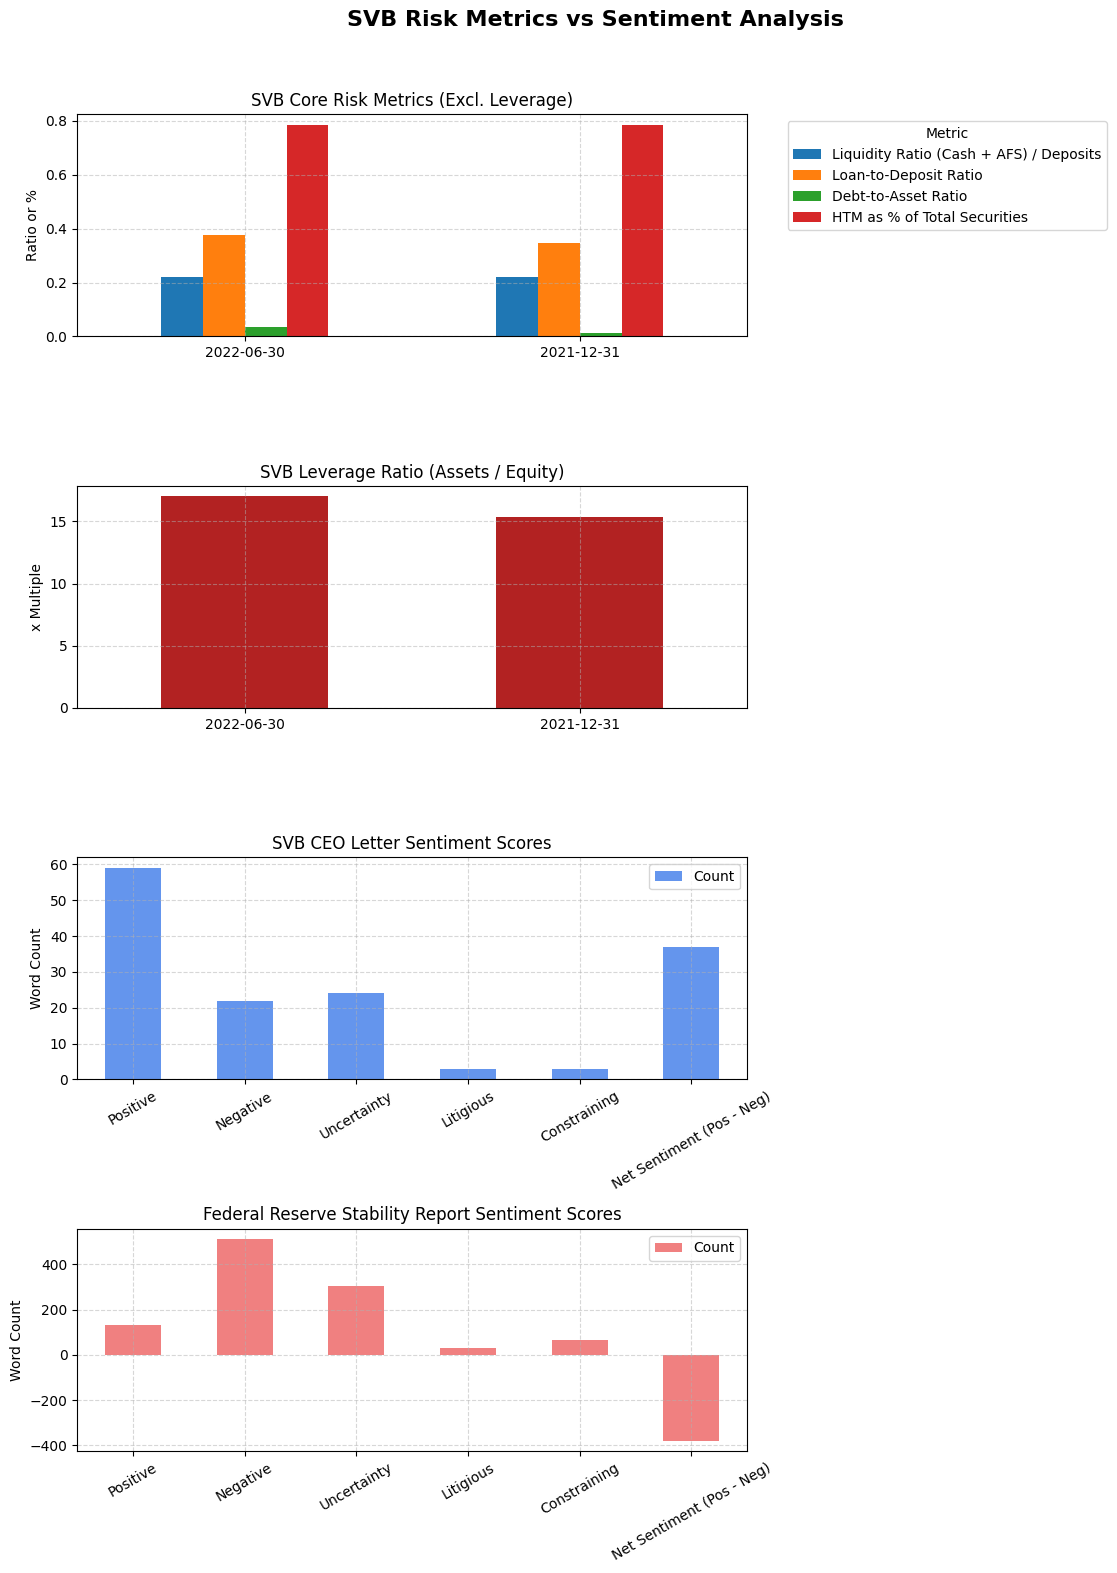

In [35]:
import matplotlib.pyplot as plt

# Separate the leverage ratio for clearer comparison
leverage = metrics[["Leverage Ratio (Assets / Equity proxy)"]]
non_leverage = metrics.drop(columns=["Leverage Ratio (Assets / Equity proxy)"])

# ---- Plot Setup ---- #
fig, axs = plt.subplots(4, 1, figsize=(12, 16))  # 4 vertical subplots
fig.suptitle("SVB Risk Metrics vs Sentiment Analysis", fontsize=16, fontweight="bold")

# ---- Plot Bank Metrics (Excl. Leverage) ---- #
non_leverage.plot(kind="bar", ax=axs[0], legend=True)
axs[0].set_title("SVB Core Risk Metrics (Excl. Leverage)")
axs[0].set_ylabel("Ratio or %")
axs[0].tick_params(axis="x", rotation=0)
axs[0].grid(True, linestyle="--", alpha=0.5)
axs[0].legend(title="Metric", bbox_to_anchor=(1.05, 1), loc="upper left")

# ---- Plot Leverage ---- #
leverage.plot(kind="bar", ax=axs[1], color="firebrick", legend=False)
axs[1].set_title("SVB Leverage Ratio (Assets / Equity)")
axs[1].set_ylabel("x Multiple")
axs[1].tick_params(axis="x", rotation=0)
axs[1].grid(True, linestyle="--", alpha=0.5)

# ---- Plot SVB Sentiment ---- #
svb_sentiment.plot(kind="bar", ax=axs[2], color="cornflowerblue")
axs[2].set_title("SVB CEO Letter Sentiment Scores")
axs[2].set_ylabel("Word Count")
axs[2].grid(True, linestyle="--", alpha=0.5)
axs[2].tick_params(axis='x', labelrotation=30)

# ---- Plot FDIC Sentiment ---- #
fdic_sentiment.plot(kind="bar", ax=axs[3], color="lightcoral")
axs[3].set_title("Federal Reserve Stability Report Sentiment Scores")
axs[3].set_ylabel("Word Count")
axs[3].grid(True, linestyle="--", alpha=0.5)
axs[3].tick_params(axis='x', labelrotation=30)

plt.tight_layout(rect=[0, 0, 0.95, 0.96])
plt.show()


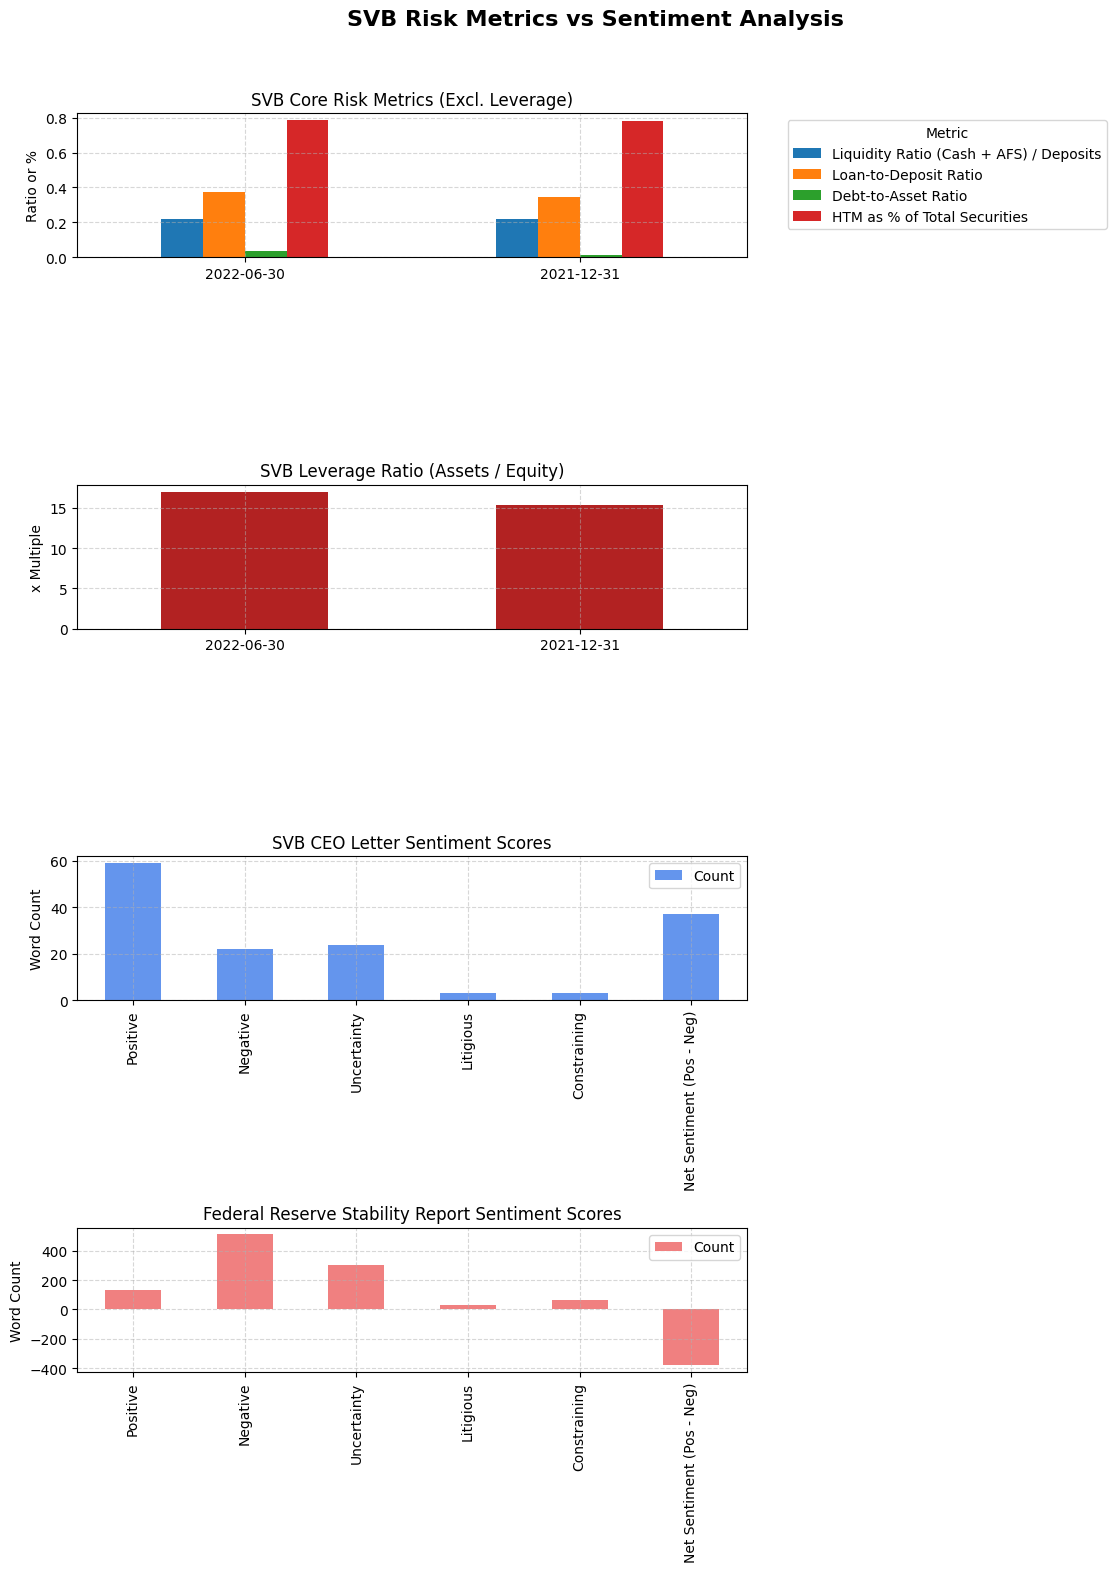

In [ ]:
import matplotlib.pyplot as plt

# Separate the leverage ratio for clearer comparison
leverage = metrics[["Leverage Ratio (Assets / Equity proxy)"]]
non_leverage = metrics.drop(columns=["Leverage Ratio (Assets / Equity proxy)"])

# ---- Plot Setup ---- #
fig, axs = plt.subplots(4, 1, figsize=(12, 16))  # 4 vertical subplots
fig.suptitle("SVB Risk Metrics vs Sentiment Analysis", fontsize=16, fontweight="bold")

# ---- Plot Bank Metrics (Excl. Leverage) ---- #
non_leverage.plot(kind="bar", ax=axs[0], legend=True)
axs[0].set_title("SVB Core Risk Metrics (Excl. Leverage)")
axs[0].set_ylabel("Ratio or %")
axs[0].tick_params(axis="x", rotation=0)
axs[0].grid(True, linestyle="--", alpha=0.5)
axs[0].legend(title="Metric", bbox_to_anchor=(1.05, 1), loc="upper left")

# ---- Plot Leverage ---- #
leverage.plot(kind="bar", ax=axs[1], color="firebrick", legend=False)
axs[1].set_title("SVB Leverage Ratio (Assets / Equity)")
axs[1].set_ylabel("x Multiple")
axs[1].tick_params(axis="x", rotation=0)
axs[1].grid(True, linestyle="--", alpha=0.5)

# ---- Plot SVB Sentiment ---- #
svb_sentiment.plot(kind="bar", ax=axs[2], color="cornflowerblue")
axs[2].set_title("SVB CEO Letter Sentiment Scores")
axs[2].set_ylabel("Word Count")
axs[2].grid(True, linestyle="--", alpha=0.5)

# ---- Plot FDIC Sentiment ---- #
fdic_sentiment.plot(kind="bar", ax=axs[3], color="lightcoral")
axs[3].set_title("Federal Reserve Stability Report Sentiment Scores")
axs[3].set_ylabel("Word Count")
axs[3].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout(rect=[0, 0, 0.95, 0.96])  # Adjust layout to fit title & legend
plt.show()
